In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your merged stats/salary file (update path as needed)
df = pd.read_csv("seriea_2024_2025_stats/player_team_salary_stats_2024-2025_SerieA.csv")


In [29]:
# Keep only strikers/forwards for main finishing analysis
attackers = df[df['Pos'].str.contains('FW', na=False)].copy()
# Remove players with very few shots (set your own threshold)
# Example: Require at least 20 shots and 3 goals
attackers = attackers[
    (attackers['Shots'] >= 20) &
    (attackers['Goals'] >= 5) &
    (attackers['Playing Time_MP'] >= 12)  # or whatever your column is
]




In [30]:
# Calculate conversion rate and xG per shot
attackers['Shot_Conversion'] = attackers['Goals'] / attackers['Shots']
attackers['xG_per_shot'] = attackers['Expected_xG'] / attackers['Shots']
xg_mean = attackers['xG_per_shot'].mean()
conv_mean = attackers['Shot_Conversion'].mean()


Scoring goals wins matches—but not all goals are created equal. Some attackers shine by converting tough chances, while others get plenty of opportunities but struggle to finish. In this article, we use data visualization to see *how* Serie A's forwards are finishing their chances—not just how many times they find the net.

We’ll use two powerful metrics:
- **xG per shot:** How good are the chances each player gets?
- **Shot conversion rate:** How often do those shots turn into goals?

And then, we’ll go a step further, seeing who is outperforming or underperforming their expected goals (xG).


**xG per shot:**  
- Measures the average "quality" of each shot (higher means more big chances).
  
**Shot conversion rate:**  
- Percent of shots that become goals.

We look at all attackers with at least 20 shots in Serie A [2024–25] for a fair comparison.  
*Data via [FBref](https://fbref.com/), plots built in Python (see code below).*


### How Serie A Attackers Finish Their Chances

![Insert: Quadrant Plot - All Names, Bubbles = Shots]

- Each dot: a player (bubble size = shot volume)
- Red/blue dashed lines: league averages for xG/shot and conversion rate
- Quadrants: Clinical Finishers, Poachers, Underperformers, Volume Shooters

*See the legend for bubble sizes. All attackers labeled. Key quadrant leaders boxed for clarity.*


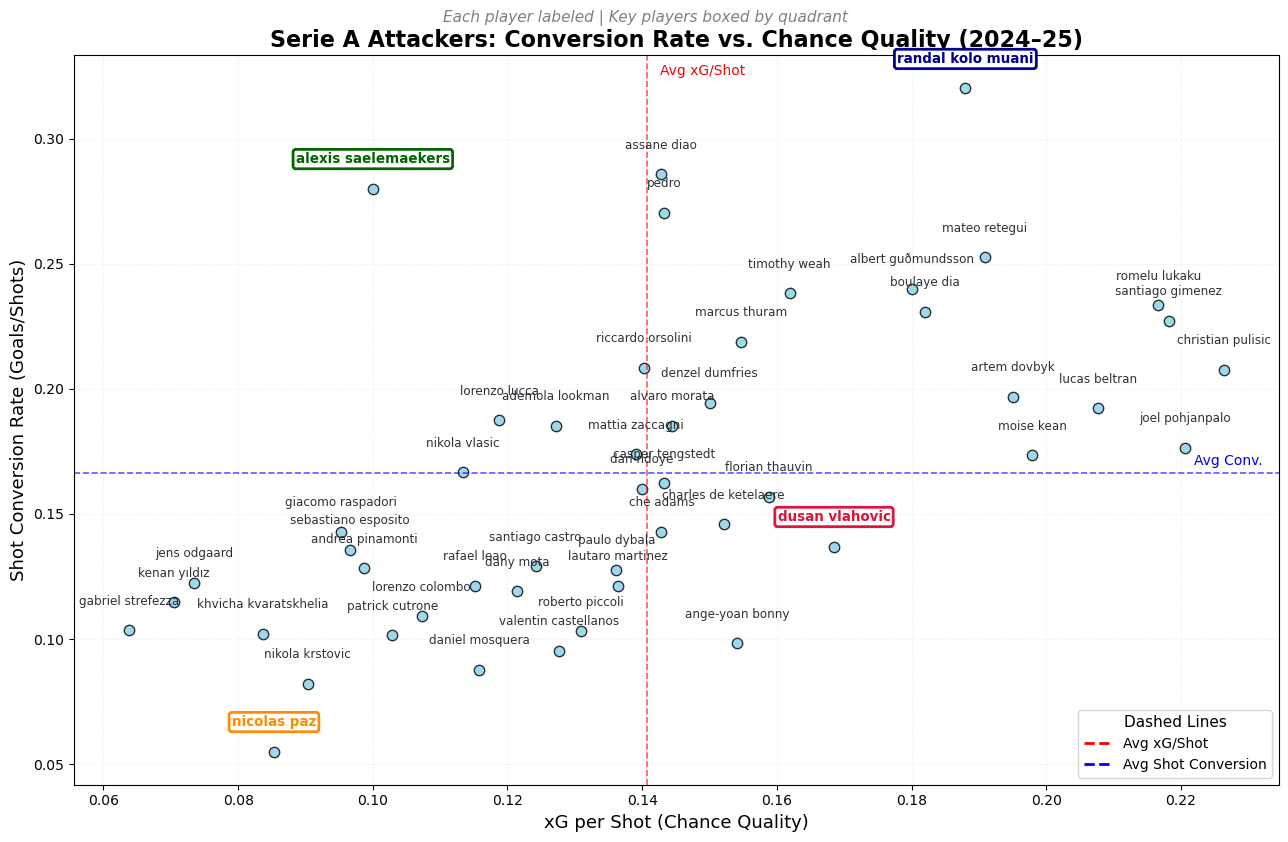

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(13, 9))

dot_size = 56

xbar = attackers['xG_per_shot'].mean()
ybar = attackers['Shot_Conversion'].mean()

# Find Mauni's index, or use another default if not present
mauni_idx = attackers[attackers['Player'].str.contains("Muani", case=False, na=False)].index
if not mauni_idx.empty:
    idx_mauni = mauni_idx[0]
else:
    # fallback: use the statistically top right player as before
    idx_mauni = attackers[(attackers['xG_per_shot'] > xbar) & (attackers['Shot_Conversion'] > ybar)].sort_values(
        ['xG_per_shot', 'Shot_Conversion'], ascending=[False, False]
    ).index[0]

# Quadrant highlight indices
highlight_indices = []

# Top left: Clinical finisher (Saelemaekers if present)
tl = attackers[(attackers['xG_per_shot'] < xbar) & (attackers['Shot_Conversion'] > ybar)]
if not tl.empty and 'Saelemaekers' in tl['Player'].values:
    idx_tl = tl[tl['Player'] == 'Saelemaekers'].index[0]
elif not tl.empty:
    idx_tl = tl['Shot_Conversion'].idxmax()
else:
    idx_tl = None
if idx_tl is not None: highlight_indices.append(idx_tl)

# Top right: Always Mauni
highlight_indices.append(idx_mauni)

# Bottom left: lowest conversion
bl = attackers[(attackers['xG_per_shot'] < xbar) & (attackers['Shot_Conversion'] < ybar)]
if not bl.empty:
    idx_bl = bl['Shot_Conversion'].idxmin()
    highlight_indices.append(idx_bl)

# Bottom right: highest xG/shot, lowest conv
br = attackers[(attackers['xG_per_shot'] > xbar) & (attackers['Shot_Conversion'] < ybar)]
if not br.empty:
    idx_br = br['xG_per_shot'].idxmax()
    highlight_indices.append(idx_br)

# Annotate all players except those boxed
for i, row in attackers.iterrows():
    if i not in highlight_indices:
        plt.text(
            row['xG_per_shot'],
            row['Shot_Conversion'] + 0.009,
            row['Player'],
            fontsize=8.6,
            ha='center',
            va='bottom',
            color='#24292f',
            alpha=0.96,
            zorder=4
        )

quad_colors = ['darkgreen', 'darkblue', 'darkorange', 'crimson']
for idx, color in zip(highlight_indices, quad_colors):
    row = attackers.loc[idx]
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.009,
        row['Player'],
        fontsize=9.7,
        ha='center',
        va='bottom',
        color=color,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.20", edgecolor=color, facecolor='white', lw=2, alpha=0.99),
        zorder=6
    )

plt.scatter(
    attackers['xG_per_shot'],
    attackers['Shot_Conversion'],
    s=dot_size,
    c='skyblue',
    alpha=0.8,
    edgecolor='k'
)

plt.axvline(xbar, color='red', linestyle='--', linewidth=1.2, alpha=0.65, zorder=2)
plt.axhline(ybar, color='blue', linestyle='--', linewidth=1.2, alpha=0.65, zorder=2)
plt.text(xbar+0.002, plt.ylim()[1]*0.99, "Avg xG/Shot", color='red', fontsize=10, ha='left', va='top')
plt.text(plt.xlim()[1]*0.99, ybar+0.002, "Avg Conv.", color='blue', fontsize=10, ha='right', va='bottom')

plt.xlabel('xG per Shot (Chance Quality)', fontsize=13)
plt.ylabel('Shot Conversion Rate (Goals/Shots)', fontsize=13)
plt.title('Serie A Attackers: Conversion Rate vs. Chance Quality (2024–25)', fontsize=16, fontweight='bold')
plt.suptitle('Each player labeled | Key players boxed by quadrant', fontsize=11, color='gray', y=0.93, style='italic')
plt.grid(alpha=0.22, linestyle=':', zorder=0)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Legend for dashed lines
legend_elements = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Avg xG/Shot'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Avg Shot Conversion')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True, title="Dashed Lines", title_fontsize=11)

plt.savefig("seriea_quadrant_dots_mauni.png", dpi=220, bbox_inches='tight')
plt.show()
